In [116]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

# Loading the dataset

In [2]:
#loading the json file that contains the dataset with features
data= pd.read_json("tops_fashion.json")

In [3]:
data.shape

(183138, 19)

In [4]:
print("no of data points:", data.shape[0],\
     " no of features:", data.shape[1])

no of data points: 183138  no of features: 19


In [5]:
#columns of the data
data.columns

Index(['asin', 'author', 'availability', 'availability_type', 'brand', 'color',
       'editorial_reivew', 'editorial_review', 'formatted_price',
       'large_image_url', 'manufacturer', 'medium_image_url', 'model',
       'product_type_name', 'publisher', 'reviews', 'sku', 'small_image_url',
       'title'],
      dtype='object')

In [6]:
data.head(1)

,asin,author,availability,availability_type,brand,color,editorial_reivew,editorial_review,formatted_price,large_image_url,manufacturer,medium_image_url,model,product_type_name,publisher,reviews,sku,small_image_url,title
0,B016I2TS4W,None,None,None,FNC7C,None,NaN,Minions Como Superheroes Ironman Women's O Nec...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Long Sleeve R...


I will be using only 6 of these featues in the dataset:
    1. asin  ( Amazon standard identification number)
    2. brand ( brand to which the product belongs to )
    3. color ( Color information of apparel, it can contain many colors as a value ex: red and black stripes ) 
    4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
    5. medium_image_url  ( url of the image )
    6. title (title of the product.)
    7. formatted_price (price of the product)

In [7]:
data= data[["asin", 'brand','color','product_type_name', 'medium_image_url', 'title','formatted_price']]

In [8]:
data.shape

(183138, 7)

# Handling Missing Data

**Basic Stats: product_type_name**

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183138 entries, 0 to 183137
Data columns (total 7 columns):
asin                 183138 non-null object
brand                182987 non-null object
color                64956 non-null object
product_type_name    183138 non-null object
medium_image_url     183138 non-null object
title                183138 non-null object
formatted_price      28395 non-null object
dtypes: object(7)
memory usage: 9.8+ MB


brand: 183138-182987 = 151 missing values

color: 183138-64956 = 118182 missing values

formatted_price: 183138- 28395 = 15474 missing values

In [10]:
data["product_type_name"].describe()

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object

In [11]:
freq_prodname= Counter(list(data['product_type_name']))
freq_prodname.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

**Basic Stats: brand**

In [12]:
data["brand"].describe()

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object

In [13]:
freq_brand= Counter(list(data['brand']))
freq_brand.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

**Basic Stats: color**

In [14]:
data['color'].describe()

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object

Out of all the products, (13207/183138) 7.2% of the clothes are black in color.

35.4% of the clothes have color information

In [15]:
freq_color= Counter(list(data['color']))
freq_color.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

Most common colors contain information like "None", "*" and "multi", which dont make sense.

**Basic Stats: formatted_price**

In [16]:
data['formatted_price'].describe()

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object

Only 15.5% of products have price information

In [17]:
freq_price= Counter(list(data['formatted_price']))
freq_price.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

Basic Stats: title

In [18]:
data['title'].describe()

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object

The above tells that for all products the title information is present and a large no of products have unique titles.

**Removing Null Values**

In [19]:
data= data.loc[~data['formatted_price'].isnull()]

In [20]:
data= data.loc[~data['color'].isnull()]

In [21]:
data.shape

(28385, 7)

In [22]:
data.to_pickle("28k_data_pickle")

In [23]:
# download the images
#I have added break in the end as I dont want to download the all the images each time I run the code. I could have commented the code but below is what I prefer.

from PIL import Image
import requests
from io import BytesIO

for i,v in data.iterrows():
        url = v['medium_image_url']
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img.save('28k_images/'+v['asin']+'.jpeg')
        break

# Handle Duplicate Values

As we can see below there are multiple product inforamtion for the same product:
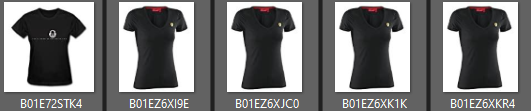

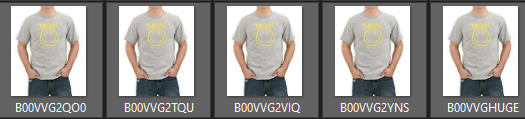

In [22]:
sum(data.duplicated("title"))
#there are 2325 products which have same title but different color

2325

In [23]:
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]

In [24]:
data_sorted.sort_values("title", inplace=True, ascending=False)

c:\users\adrat\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
pd.set_option('display.max_colwidth', -1)

In [26]:
data_sorted["title"].head()

61973     Éclair Women's Printed Thin Strap Blouse Black - Junior XL                      
133820    xiaoming Womens Sleeveless Loose Long T-shirts Top Blouse Shirts                
81461     xiaoming Women's White Long Sleeve Single Breast Loose Cotton Linen Blouse Shirt
75995     xiaoming Stripes Tank Patch/Bear Sleeve Anchor Short Embellishment Top Red Ancho
151570    xiaoming Sleeve Sheer Loose Tassel Kimono Woman Chiffon Cardigan Blouse White On
Name: title, dtype: object

**Removing rows with similar titles**

In [27]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [28]:
import itertools
dedupe_asins=[]
i=0
j=0
totalpts=data_sorted.shape[0]
while i<totalpts and j < totalpts:
    previ=i
    a= data_sorted['title'].loc[indices[i]].split()
    j=i+1
    while j< totalpts:
        b= data_sorted['title'].loc[indices[j]].split()
        length= max(len(a),len(b))
        count=0
        for k in itertools.zip_longest(a,b):
            if k[0]==k[1]:
                count+=1
                
        if length-count>2:
            dedupe_asins.append(data_sorted['asin'].loc[indices[i]])
            i=j
            break
        else:
            j+=1
    if previ==i:
        break

In [31]:
data = data.loc[data['asin'].isin(dedupe_asins)]

In [32]:
data.shape

(17592, 7)

In [33]:
data.to_pickle("17k_data_pickle")

In [34]:
data= pd.read_pickle("pickels/16k_apperal_data")

# Text Preprocessing

In [36]:
from nltk.corpus import stopwords

In [38]:
stwords= set(stopwords.words('english'))

In [44]:
def nlpfun(text, ind, col):
    if type(text) is not int:
        string=""
        for i in text.split():
            word= ("".join(e for e in i if e.isalnum()))
            word= word.lower()
            if not word in stwords:
                string+= word + " " 
        data[col][ind]=string

In [45]:
for i, v in data.iterrows():
    nlpfun(v['title'], i, "title")

In [46]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images/I/31VspXbakvL._SL160_.jpg,SHIRT,featherlite ladies long sleeve stain resistant tapered twill shirt 2xl onyx black stone,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images/I/41EpudaOiWL._SL160_.jpg,SHIRT,womens unique 100 cotton special olympics world games 2015 white size l,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images/I/41dCf%2BplpCL._SL160_.jpg,SHIRT,featherlite ladies moisture free mesh sport shirt white xxxlarge,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images/I/41Cn7jZ3O9L._SL160_.jpg,SHIRT,supernatural chibis sam dean castiel neck tshirts female purple l,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images/I/51CrsFle7%2BL._SL160_.jpg,SHIRT,fifth degree womens gold foil graphic tees junior top short sleeve printed shirt l,$6.95


In [118]:
# The below functions were taken from the appliedaicourse material (www.appliedaicourse.com)
#function to display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

# Bag Of Words

In [47]:
from nltk.stem.porter import *

In [48]:
stem= PorterStemmer()

In [53]:
stem.stem("ladies")

'ladi'

In [56]:
stem.stem("featherlite")

'featherlit'

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
titlevec = CountVectorizer()
titlefeat   = titlevec.fit_transform(data['title'])
titlefeat.get_shape()

(16042, 12609)

In [119]:
from sklearn.metrics import pairwise_distances
def bow(text, no_similar):
    pairdist= pairwise_distances(titlefeat, titlefeat[text])
    #store indices of pairs with smallest distances
    indices= np.argsort(pairdist.flatten())[0:no_similar]
    #store distances of pairs with smallest distances
    pdist= np.sort(pairdist.flatten())[0:no_similar]
    # dataframe indices of pairs of smallest distances
    df_ind= list(data.index[indices])
    for i in range(0, len(indices)):
        get_result(indices[i],data['title'].loc[df_ind[0]], data['title'].loc[df_ind[i]], data['medium_image_url'].loc[df_ind[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_ind[i]])
        print ('Brand:', data['brand'].loc[df_ind[i]])
        print ('Title:', data['title'].loc[df_ind[i]])
        print ('Euclidean similarity with the query image :', pdist[i])


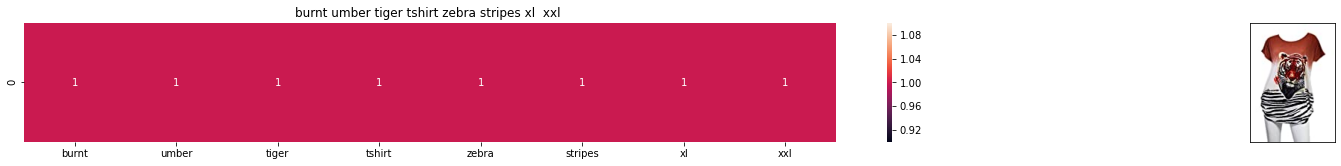

ASIN : B00JXQB5FQ
Brand: Si Row
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 0.0


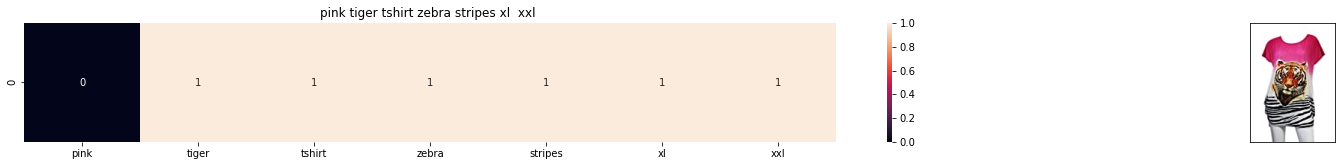

ASIN : B00JXQASS6
Brand: Si Row
Title: pink tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 1.7320508075688772


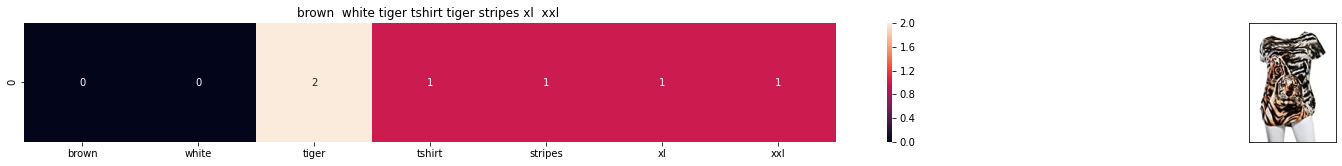

ASIN : B00JXQCWTO
Brand: Si Row
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean similarity with the query image : 2.449489742783178


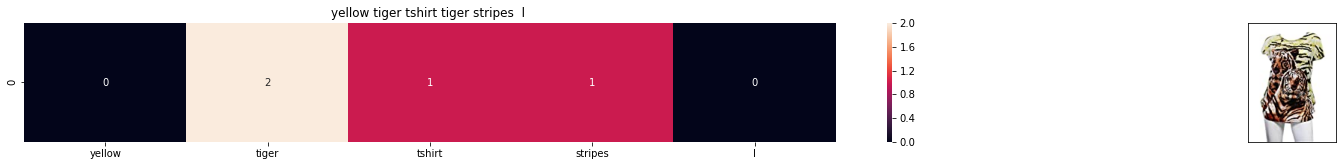

ASIN : B00JXQCUIC
Brand: Si Row
Title: yellow tiger tshirt tiger stripes  l 
Euclidean similarity with the query image : 2.6457513110645907


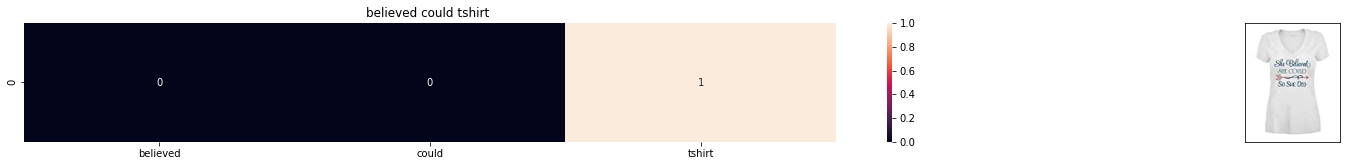

ASIN : B07568NZX4
Brand: Rustic Grace
Title: believed could tshirt 
Euclidean similarity with the query image : 3.0


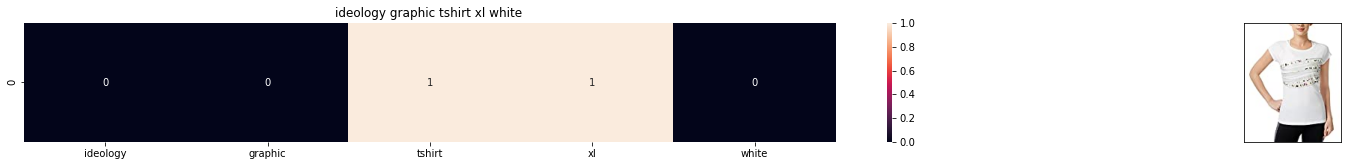

ASIN : B01NB0NKRO
Brand: Ideology
Title: ideology graphic tshirt xl white 
Euclidean similarity with the query image : 3.0


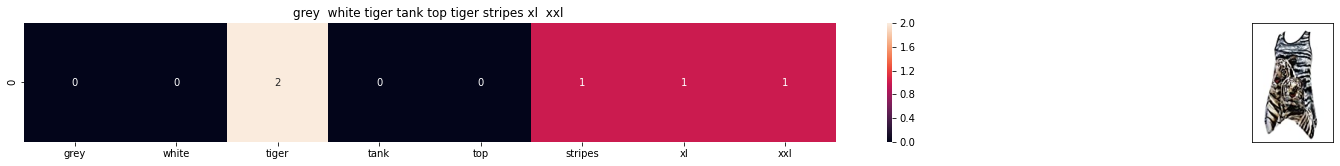

ASIN : B00JXQAFZ2
Brand: Si Row
Title: grey  white tiger tank top tiger stripes xl  xxl 
Euclidean similarity with the query image : 3.0


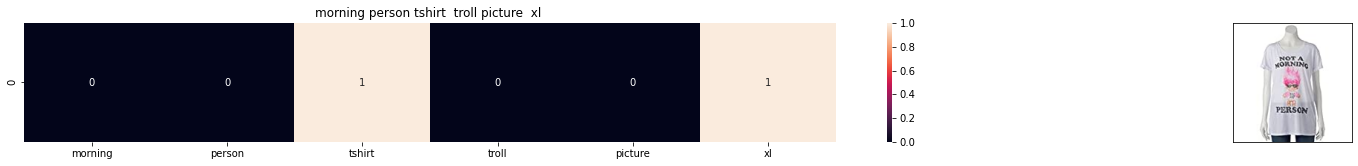

ASIN : B01CLS8LMW
Brand: Awake
Title: morning person tshirt  troll picture  xl 
Euclidean similarity with the query image : 3.1622776601683795


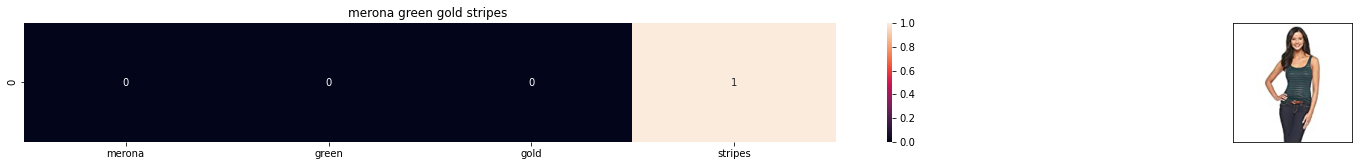

ASIN : B01KVZUB6G
Brand: Merona
Title: merona green gold stripes 
Euclidean similarity with the query image : 3.1622776601683795


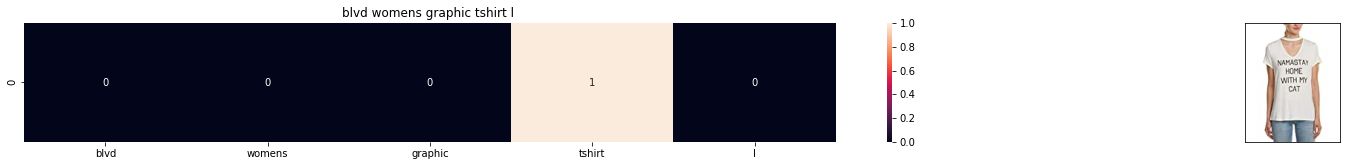

ASIN : B0733R2CJK
Brand: BLVD
Title: blvd womens graphic tshirt l 
Euclidean similarity with the query image : 3.1622776601683795


In [120]:
bow(12566,10)

# TF-IDF Vectorizer

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [81]:
title_vec= TfidfVectorizer(min_df=0)

In [82]:
title_feat= title_vec.fit_transform(data['title'])

In [83]:
# This outputs a sparse matrix. Below is no of datapoints * words in corpus
title_feat.shape

(16042, 12609)

In [121]:
def tfidfmod(text, no_similar):
    pairdist= pairwise_distances(titlefeat, titlefeat[text])
    #store indices of pairs with smallest distances
    indices= np.argsort(pairdist.flatten())[0:no_similar]
    #store distances of pairs with smallest distances
    pdist= np.sort(pairdist.flatten())[0:no_similar]
    # dataframe indices of pairs of smallest distances
    df_ind= list(data.index[indices])
    for i in range(0, len(indices)):
        get_result(indices[i],data['title'].loc[df_ind[0]], data['title'].loc[df_ind[i]], data['medium_image_url'].loc[df_ind[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_ind[i]])
        print ('Brand:', data['brand'].loc[df_ind[i]])
        print ('Title:', data['title'].loc[df_ind[i]])
        print ('Euclidean similarity with the query image :', pdist[i])

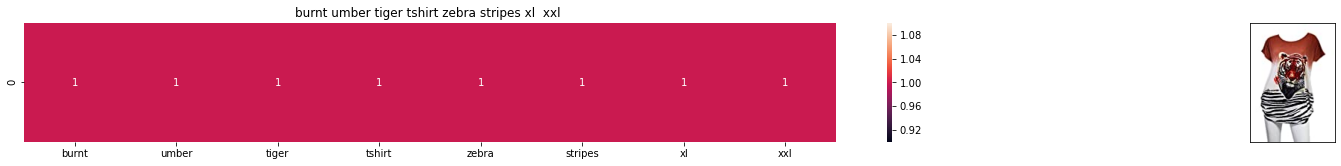

ASIN : B00JXQB5FQ
Brand: Si Row
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 0.0


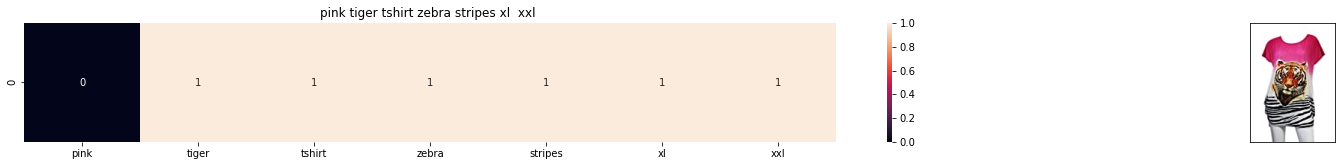

ASIN : B00JXQASS6
Brand: Si Row
Title: pink tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 1.7320508075688772


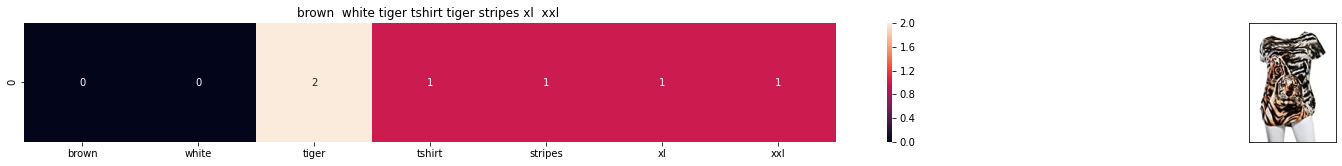

ASIN : B00JXQCWTO
Brand: Si Row
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean similarity with the query image : 2.449489742783178


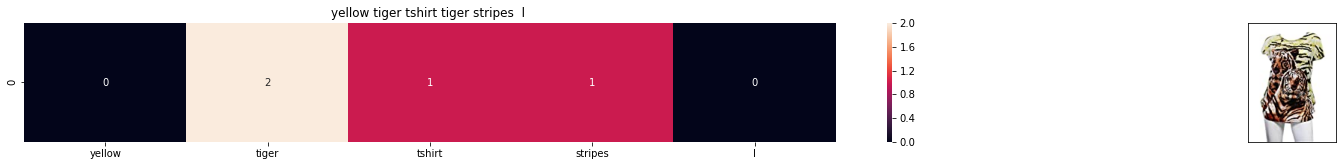

ASIN : B00JXQCUIC
Brand: Si Row
Title: yellow tiger tshirt tiger stripes  l 
Euclidean similarity with the query image : 2.6457513110645907


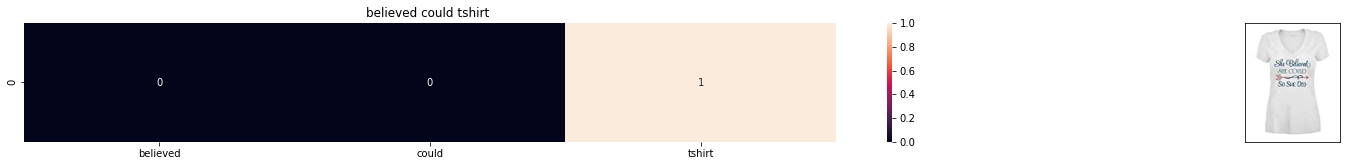

ASIN : B07568NZX4
Brand: Rustic Grace
Title: believed could tshirt 
Euclidean similarity with the query image : 3.0


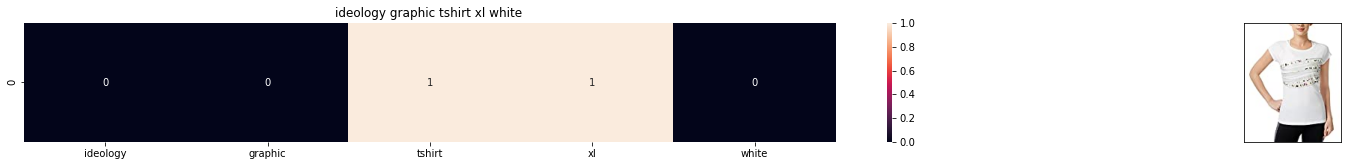

ASIN : B01NB0NKRO
Brand: Ideology
Title: ideology graphic tshirt xl white 
Euclidean similarity with the query image : 3.0


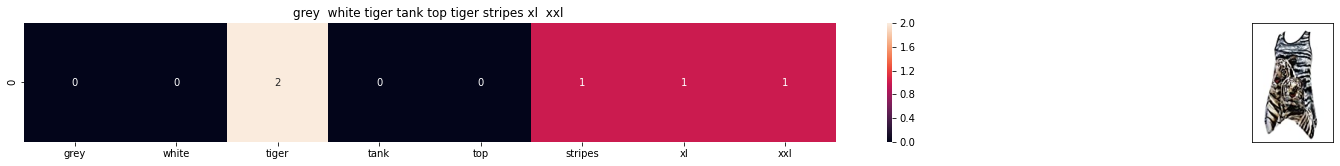

ASIN : B00JXQAFZ2
Brand: Si Row
Title: grey  white tiger tank top tiger stripes xl  xxl 
Euclidean similarity with the query image : 3.0


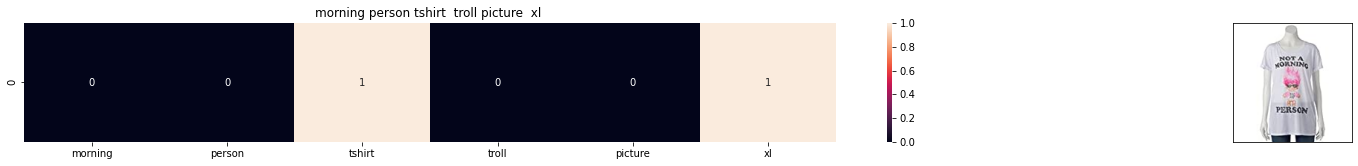

ASIN : B01CLS8LMW
Brand: Awake
Title: morning person tshirt  troll picture  xl 
Euclidean similarity with the query image : 3.1622776601683795


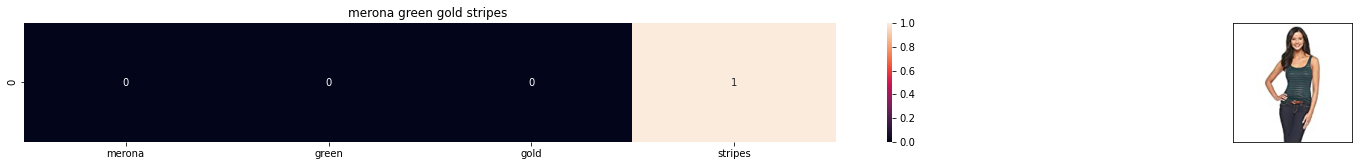

ASIN : B01KVZUB6G
Brand: Merona
Title: merona green gold stripes 
Euclidean similarity with the query image : 3.1622776601683795


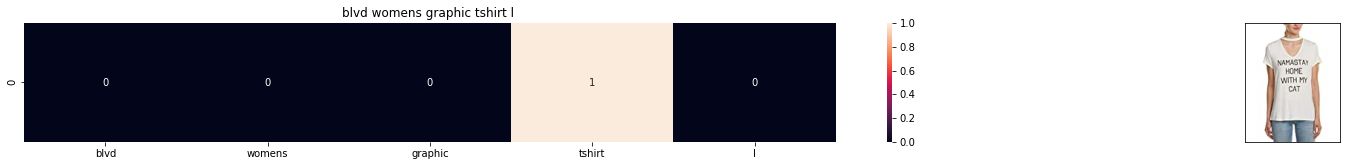

ASIN : B0733R2CJK
Brand: BLVD
Title: blvd womens graphic tshirt l 
Euclidean similarity with the query image : 3.1622776601683795


In [122]:
tfidfmod(12566, 10)

Since there are many words in different titles that do not repeat, we can safely drop TF and compute similarity on the basis of IDF value.

# IDF Based Similarity

In [86]:
from sklearn.feature_extraction.text import CountVectorizer

In [87]:
idfvec= CountVectorizer()

In [93]:
idf_feat= idfvec.fit_transform(data['title'])
idf_feat= idf_feat.astype(np.float)

In [101]:
#returns the no of documents which have the given word
import math
def wordcontain(word):
    return sum(1 for i in data['title'] if word in i.split())
def idf(word):
    # formula for calculating idf
    return math.log(data.shape[0] / (wordcontain(word)))

In [102]:
for i in idfvec.vocabulary_.keys():
    # finding idf value for each word
    idfval= idf(i)
    #replacing count values with idf values in idf_feat
    for j in idf_feat[:,idfvec.vocabulary_[i]].nonzero()[0]:
        idf_feat[j, idfvec.vocabulary_[i]]= idfval
        

In [123]:
def idfmodel(text, no_similar):
    pairdist= pairwise_distances(titlefeat, titlefeat[text])
    #store indices of pairs with smallest distances
    indices= np.argsort(pairdist.flatten())[0:no_similar]
    #store distances of pairs with smallest distances
    pdist= np.sort(pairdist.flatten())[0:no_similar]
    # dataframe indices of pairs of smallest distances
    df_ind= list(data.index[indices])
    for i in range(0, len(indices)):
        get_result(indices[i],data['title'].loc[df_ind[0]], data['title'].loc[df_ind[i]], data['medium_image_url'].loc[df_ind[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_ind[i]])
        print ('Brand:', data['brand'].loc[df_ind[i]])
        print ('Title:', data['title'].loc[df_ind[i]])
        print ('Euclidean similarity with the query image :', pdist[i])

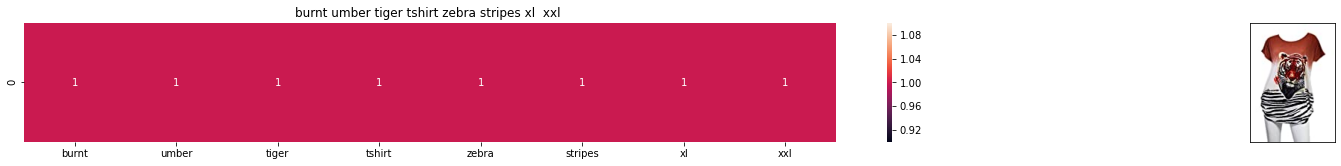

ASIN : B00JXQB5FQ
Brand: Si Row
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 0.0


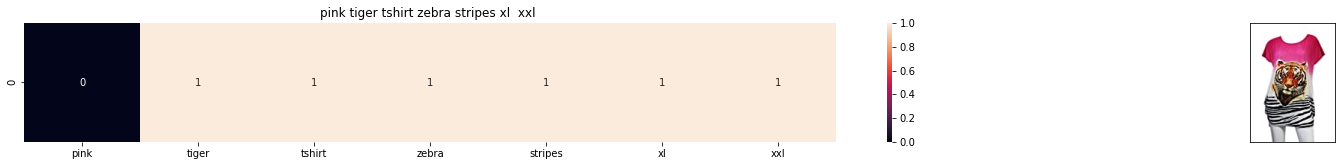

ASIN : B00JXQASS6
Brand: Si Row
Title: pink tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 1.7320508075688772


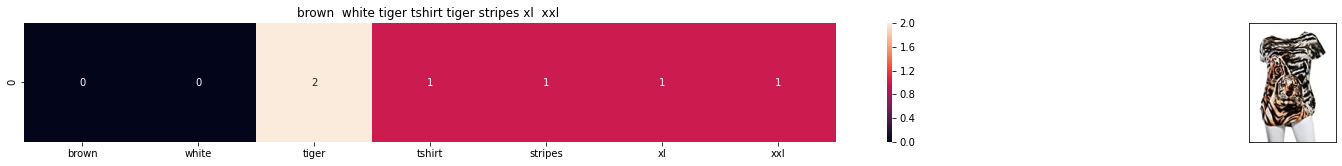

ASIN : B00JXQCWTO
Brand: Si Row
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean similarity with the query image : 2.449489742783178


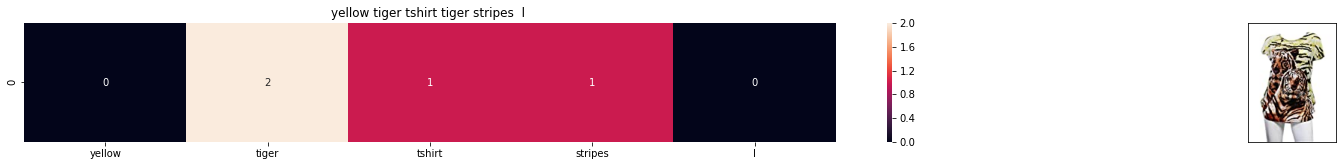

ASIN : B00JXQCUIC
Brand: Si Row
Title: yellow tiger tshirt tiger stripes  l 
Euclidean similarity with the query image : 2.6457513110645907


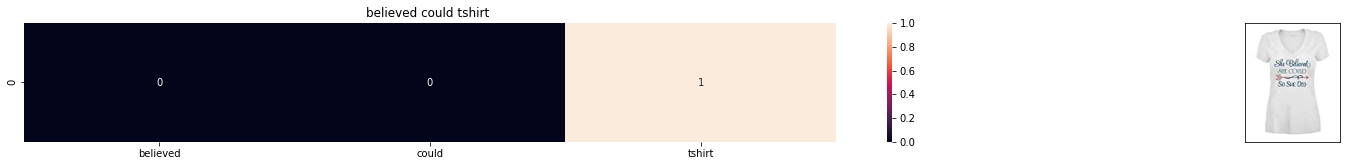

ASIN : B07568NZX4
Brand: Rustic Grace
Title: believed could tshirt 
Euclidean similarity with the query image : 3.0


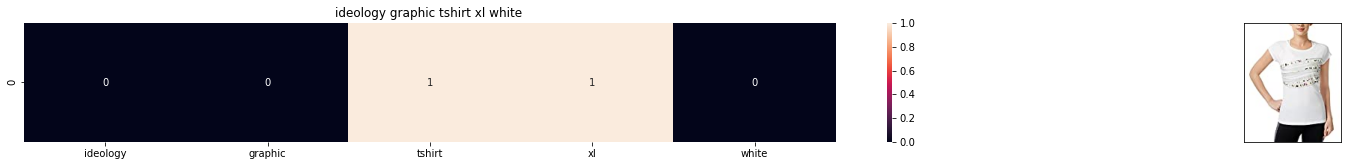

ASIN : B01NB0NKRO
Brand: Ideology
Title: ideology graphic tshirt xl white 
Euclidean similarity with the query image : 3.0


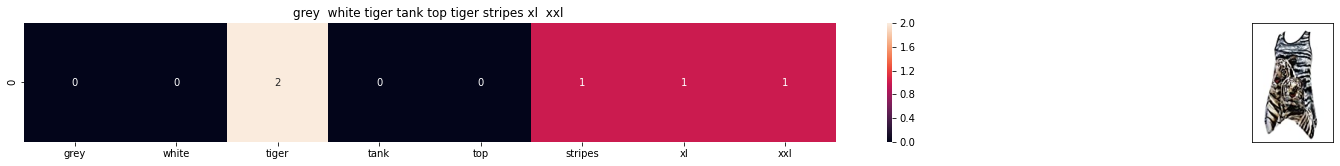

ASIN : B00JXQAFZ2
Brand: Si Row
Title: grey  white tiger tank top tiger stripes xl  xxl 
Euclidean similarity with the query image : 3.0


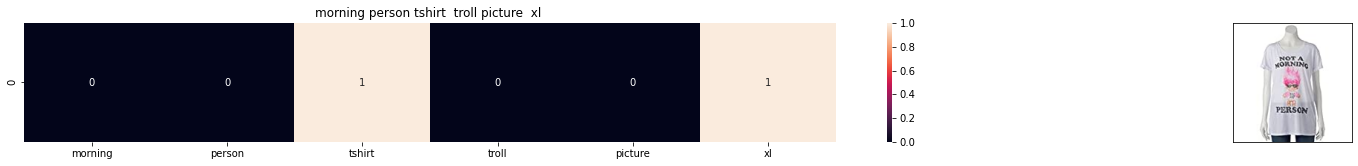

ASIN : B01CLS8LMW
Brand: Awake
Title: morning person tshirt  troll picture  xl 
Euclidean similarity with the query image : 3.1622776601683795


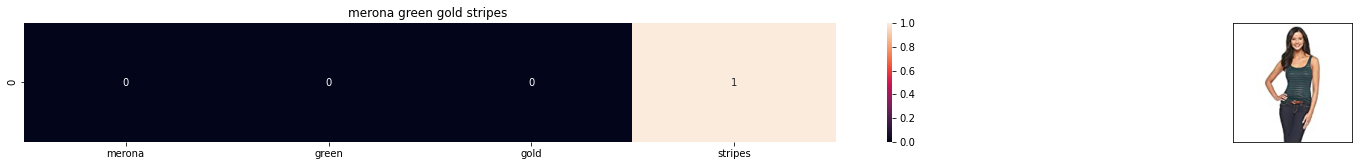

ASIN : B01KVZUB6G
Brand: Merona
Title: merona green gold stripes 
Euclidean similarity with the query image : 3.1622776601683795


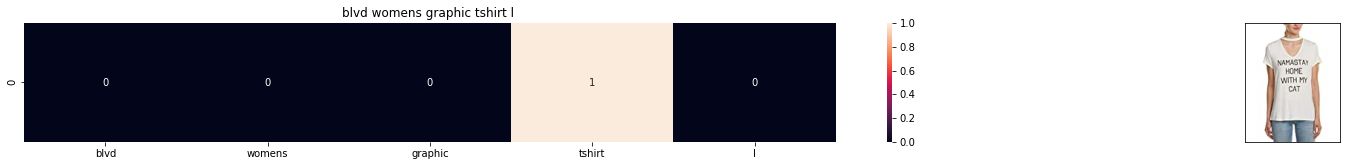

ASIN : B0733R2CJK
Brand: BLVD
Title: blvd womens graphic tshirt l 
Euclidean similarity with the query image : 3.1622776601683795


In [124]:
idfmodel(12566, 10)

# Word2Vec Model

In [107]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [110]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [112]:
vocab= model.wv.vocab.keys()

c:\users\adrat\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [114]:
print('abc')

abc


In [125]:
def get_word_vec(sentence, doc_id, m_name):
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            vec.append(np.zeros(shape=(300,)))
    return  np.array(vec)

def get_distance(vec1, vec2):
    final_dist = []
    for i in vec1:
        dist = []
        for j in vec2:
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))   
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    ax.set_xticklabels(sentence2.split())
    ax.set_yticklabels(sentence1.split())
    ax.set_title(sentence2)    
    ax = plt.subplot(gs[1])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    plt.show()

In [126]:
def buildavgw2v(sentence, no_similar, docid, m_name):
    featureVec = np.zeros((no_similar,), dtype="float32")
    nwords = 0
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idfvec.vocabulary_:
                featureVec = np.add(featureVec, idf_feat[docid, idfvec.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [129]:
docid = 0
w2v_title = []
for i in data['title']:
    w2v_title.append(buildavgw2v(i, 300, docid,'avg'))
    docid += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)


In [134]:
def avg_w2v_model(text, no_similar):
    pairdist= pairwise_distances(titlefeat, titlefeat[text])
    #store indices of pairs with smallest distances
    indices= np.argsort(pairdist.flatten())[0:no_similar]
    #store distances of pairs with smallest distances
    pdist= np.sort(pairdist.flatten())[0:no_similar]
    # dataframe indices of pairs of smallest distances
    df_ind= list(data.index[indices])
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_ind[0]],data['title'].loc[df_ind[i]], data['medium_image_url'].loc[df_ind[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_ind[i]])
        print ('Brand:', data['brand'].loc[df_ind[i]])
        print ('Title:', data['title'].loc[df_ind[i]])
        print ('Euclidean similarity with the query image :', pdist[i])

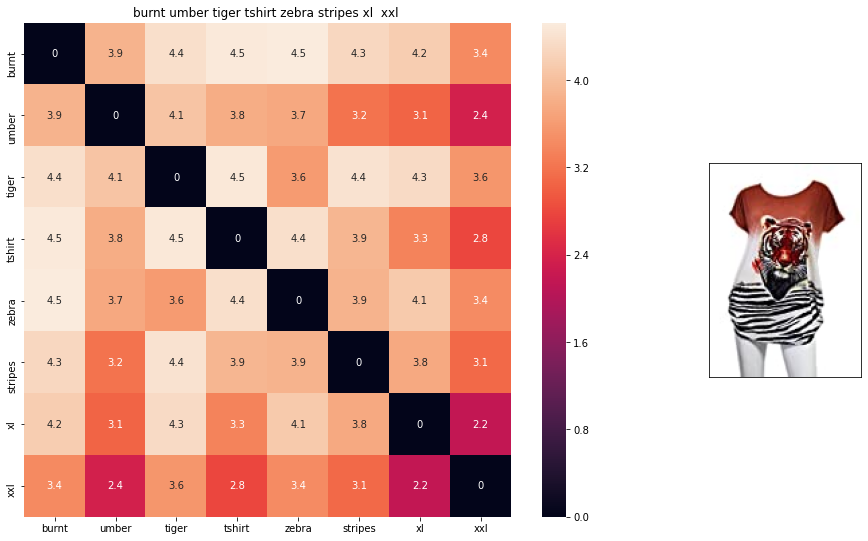

ASIN : B00JXQB5FQ
Brand: Si Row
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 0.0


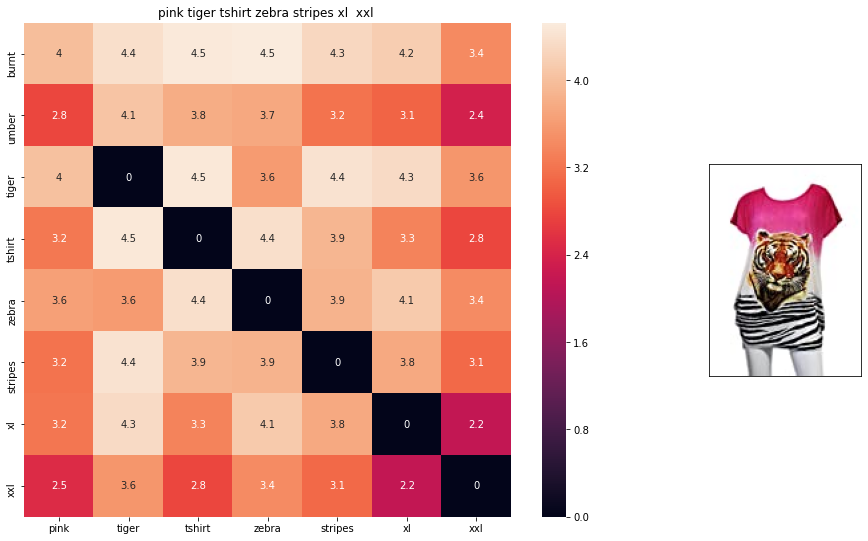

ASIN : B00JXQASS6
Brand: Si Row
Title: pink tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 1.7320508075688772


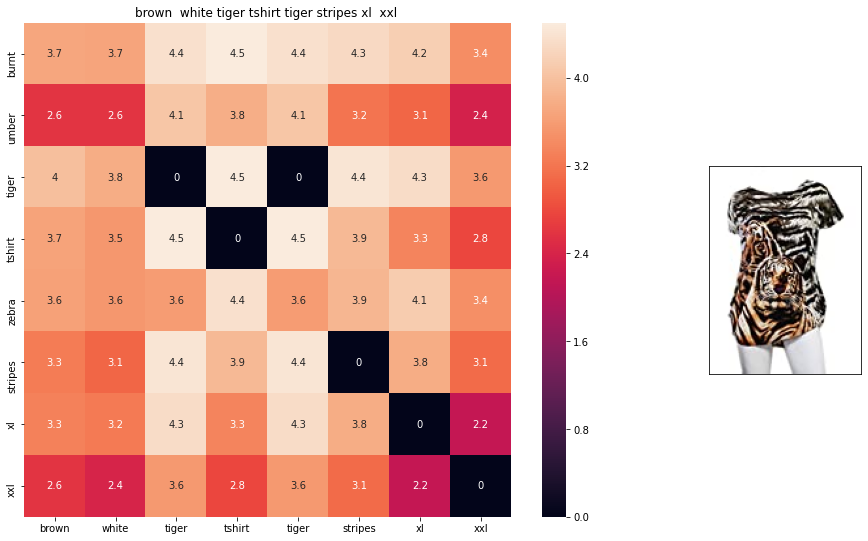

ASIN : B00JXQCWTO
Brand: Si Row
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean similarity with the query image : 2.449489742783178


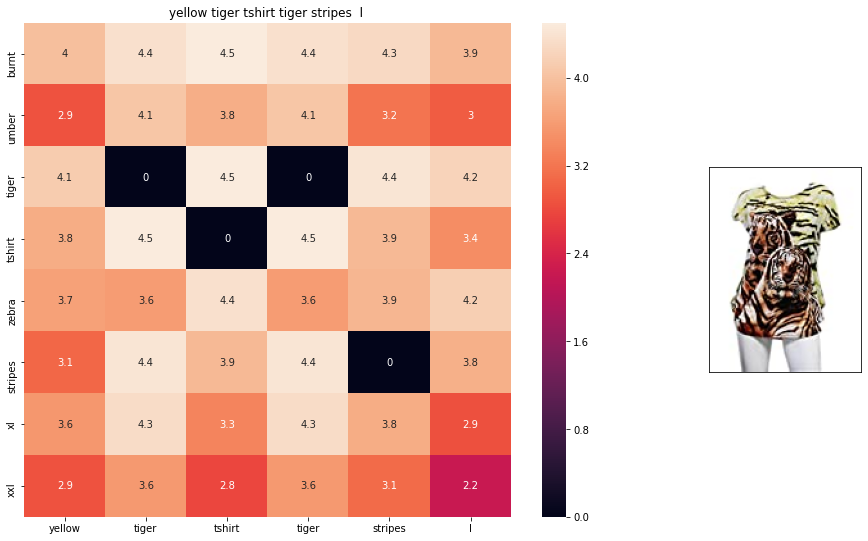

ASIN : B00JXQCUIC
Brand: Si Row
Title: yellow tiger tshirt tiger stripes  l 
Euclidean similarity with the query image : 2.6457513110645907


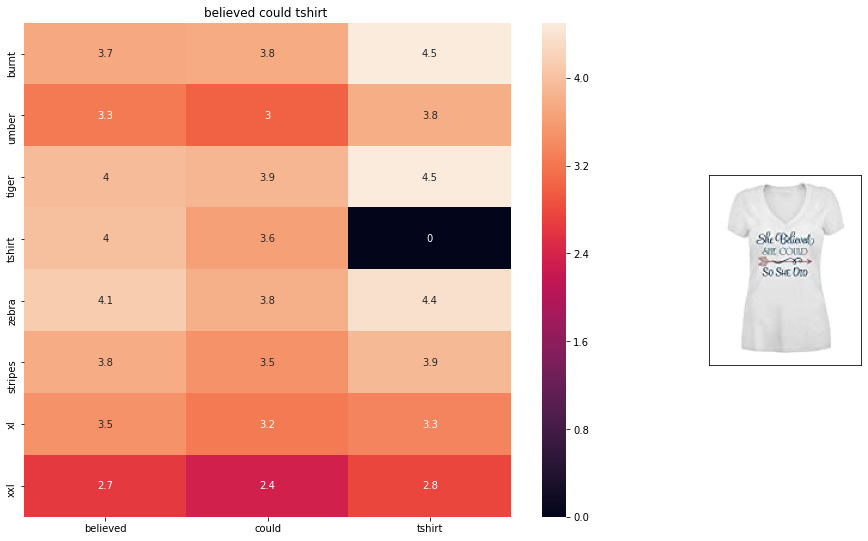

ASIN : B07568NZX4
Brand: Rustic Grace
Title: believed could tshirt 
Euclidean similarity with the query image : 3.0


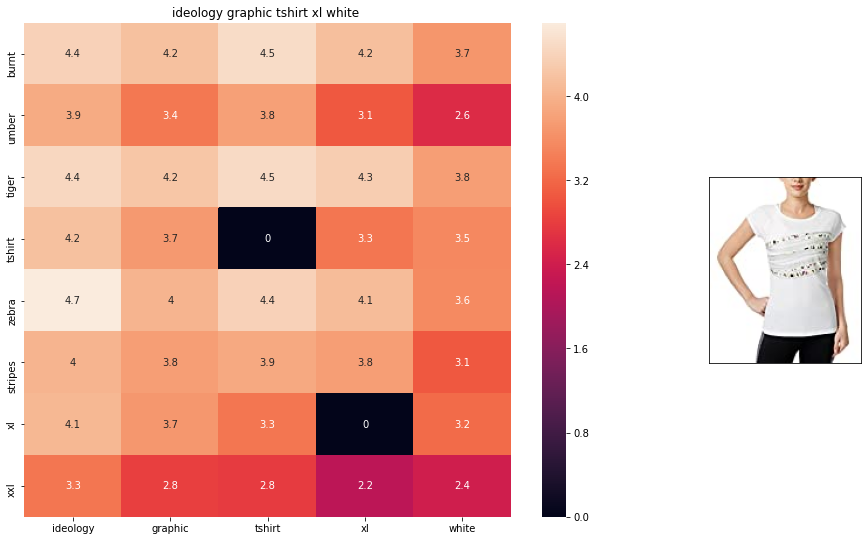

ASIN : B01NB0NKRO
Brand: Ideology
Title: ideology graphic tshirt xl white 
Euclidean similarity with the query image : 3.0


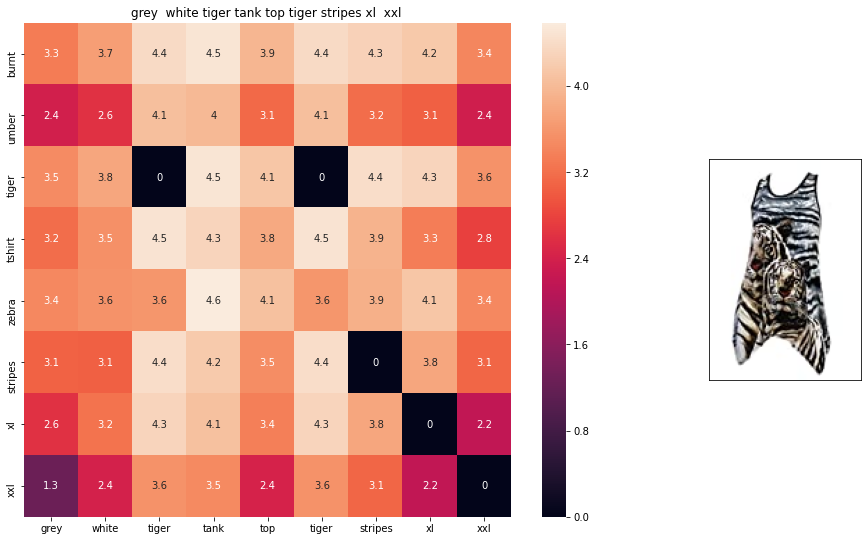

ASIN : B00JXQAFZ2
Brand: Si Row
Title: grey  white tiger tank top tiger stripes xl  xxl 
Euclidean similarity with the query image : 3.0


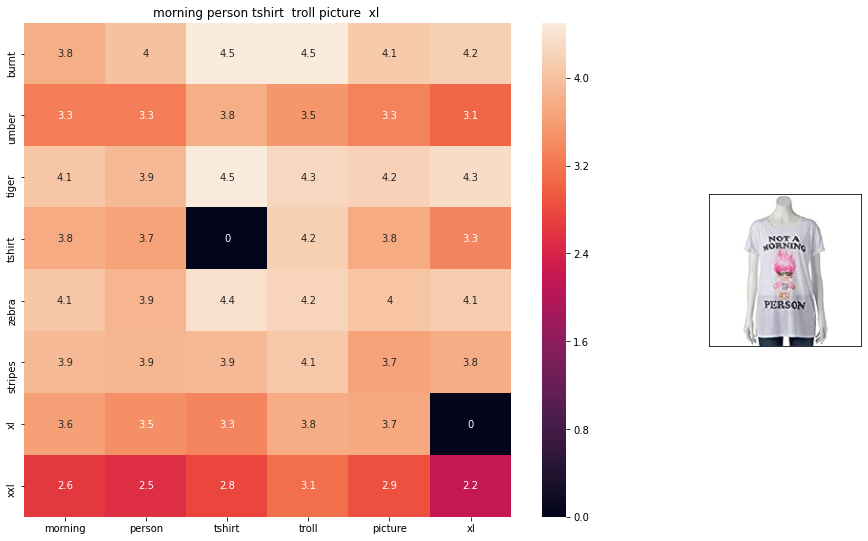

ASIN : B01CLS8LMW
Brand: Awake
Title: morning person tshirt  troll picture  xl 
Euclidean similarity with the query image : 3.1622776601683795


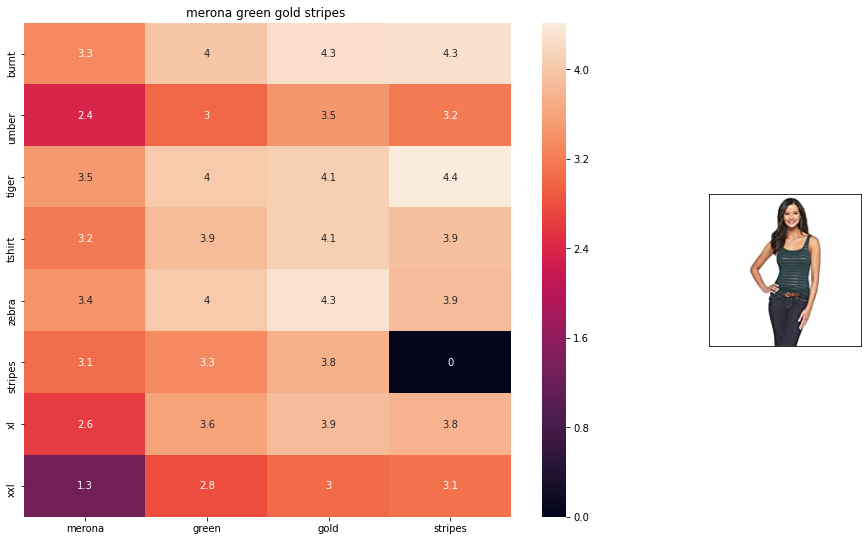

ASIN : B01KVZUB6G
Brand: Merona
Title: merona green gold stripes 
Euclidean similarity with the query image : 3.1622776601683795


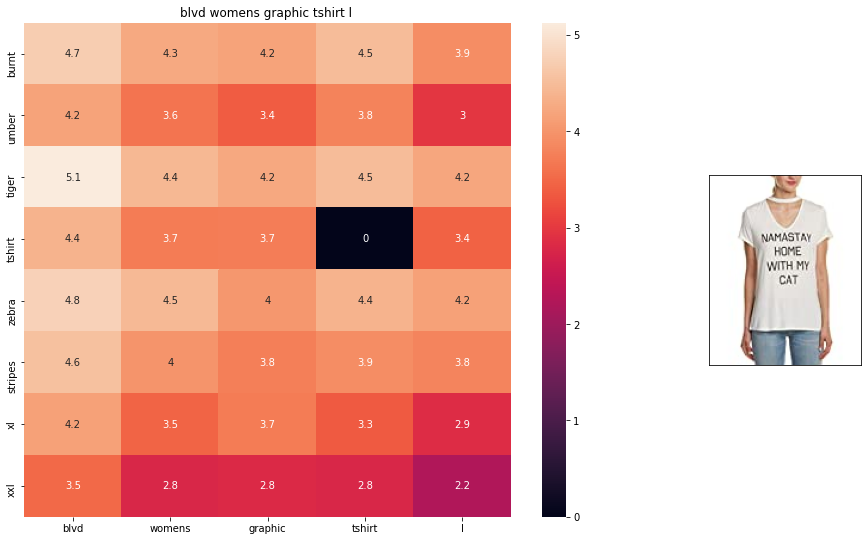

ASIN : B0733R2CJK
Brand: BLVD
Title: blvd womens graphic tshirt l 
Euclidean similarity with the query image : 3.1622776601683795


In [135]:
avg_w2v_model(12566,10)

# Using Keras and Tensorflow for Feature Extraction

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd

In [2]:
n = 16042
epochs = 50
batch_size = 1
train_dir = '16k_images/'

def save_bottlebeck_features():
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        "./",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, n // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))

In [ ]:
save_bottlebeck_features()

Found 16051 images belonging to 6 classes.


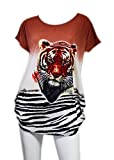

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 0.044194173
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


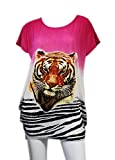

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 30.050056
Amazon Url: www.amzon.com/dp/B00JXQASS6


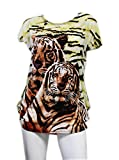

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 41.261112
Amazon Url: www.amzon.com/dp/B00JXQCUIC


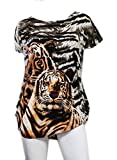

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 44.0002
Amazon Url: www.amzon.com/dp/B00JXQCWTO


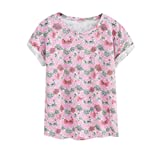

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 47.38251
Amazon Url: www.amzon.com/dp/B071FCWD97


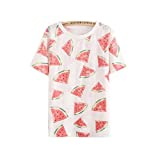

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 47.71839
Amazon Url: www.amzon.com/dp/B01JUNHBRM


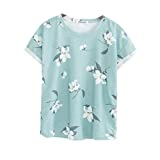

Product Title:  kawaii pastel tops tees baby blue flower design 
Euclidean Distance from input image: 47.9021
Amazon Url: www.amzon.com/dp/B071SBCY9W


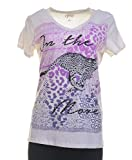

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 48.046467
Amazon Url: www.amzon.com/dp/B01CUPYBM0


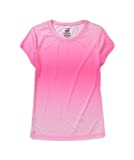

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 48.101875
Amazon Url: www.amzon.com/dp/B01F7PHXY8


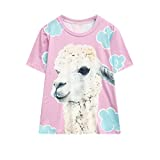

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 48.118896
Amazon Url: www.amzon.com/dp/B01I80A93G


In [7]:
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

from IPython.display import display, Image, SVG, Math, YouTubeVideo

#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(12566, 10)